# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Number of 'top domains'
n = 10

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [6]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,daniel-chromebook,dramatic-mac,calcannea-cb,mark-mac,terrestrial-mac,DESKTOP-PIMD8C0,calcannea-mac,castle3b7c9f,MalcomWare-PC,essential-cb,...,ludicrous-mac,abroad-android,tirasse-mac,appropriate-android,serotinal-mac,minesweepers-mac,misskitty-mac,traverses-mac,turing-minimacbook,score
beowulfsheehan.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
llnl.gov,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
townofplumbobs.com,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
aaa.com,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
danielstern.ca,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
rightnowtech.com,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,4,0,0,8
polyvore.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
triplelift.com,0,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
digitalartsonline.co.uk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
extremereach.io,0,23,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31


## Get list of highest accessed domains by all devices

In [7]:
top_domains = df.sort_values(by="score", ascending=False).index.values[:n]
top_domains

array(['google.com', 'gstatic.com', 'trustnetworks.com', 'googleapis.com',
       'apple.com', 'in-addr.arpa', 'clubhouse.io', 'akadns.net',
       'doubleclick.net', 'netgear.com'], dtype=object)

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = len(a)
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = len(b)
        val = val * val
        
        tot += val
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite domains by device

In [9]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['daniel-chromebook',
  array(['google.com', 'googleapis.com', 'slack-msgs.com', 'gstatic.com',
         'googleusercontent.com', 'slack.com', 'netflix.com',
         'slack-edge.com', 'trustnetworks.com', 'amazon.com'], dtype=object)],
 ['dramatic-mac',
  array(['google.com', 'apple.com', 'rbxcdn.com', 'in-addr.arpa',
         'amazonaws.com', 'ea.com', 'utun2.viscosity', 'gstatic.com',
         'origin.com', 'icloud.com'], dtype=object)],
 ['calcannea-cb',
  array(['googleapis.com', 'google.com', 'gstatic.com', 'codeanywhere.com',
         'githubusercontent.com', 'clubhouse.io', 'github.com',
         'google.co.uk', 'doubleclick.net', 'slack.com'], dtype=object)],
 ['mark-mac',
  array(['facebook.com', 'virustotal.com', 'google.com', 'twisted.ru',
         'bbc.co.uk', 'trustnetworks.com', 'gstatic.com',
         'fedoraproject.org', 'apple.com', 'clubhouse.io'], dtype=object)],
 ['terrestrial-mac',
  array(['google.com', 'gstatic.com', 'apple.com', 'googleapis.com',
         'in-

In [10]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
daniel-chromebook,"[google.com, googleapis.com, slack-msgs.com, g..."
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar..."
calcannea-cb,"[googleapis.com, google.com, gstatic.com, code..."
mark-mac,"[facebook.com, virustotal.com, google.com, twi..."
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi..."
DESKTOP-PIMD8C0,"[microsoft.com, trustnetworks.com, mcafee.com,..."
calcannea-mac,"[google.com, googleapis.com, slack.com, crashl..."
castle3b7c9f,"[netgear.com, beowulfsheehan.com, disqus.com, ..."
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
minesweepers-mac,"[google.com, github.com, in-addr.arpa, apple.c...",-0.45
tirasse-mac,"[google.com, in-addr.arpa, gstatic.com, clubho...",-1.00
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",-1.11
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-1.17
dgmac,"[google.com, clubhouse.io, apple.com, trustnet...",-1.18
theatergoing-mac,"[trustnetworks.com, google.com, microsoft.com,...",-1.31
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",-1.48
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-1.51
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",-1.55


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: spearman(domains, x)).round(2)

In [14]:
df3

,domains,daniel-chromebook,dramatic-mac,calcannea-cb,mark-mac,terrestrial-mac,DESKTOP-PIMD8C0,calcannea-mac,castle3b7c9f,MalcomWare-PC,...,dgmac,ludicrous-mac,abroad-android,tirasse-mac,appropriate-android,serotinal-mac,minesweepers-mac,misskitty-mac,traverses-mac,turing-minimacbook
device,,,,,,,,,,,,,,,,,,,,,
daniel-chromebook,"[google.com, googleapis.com, slack-msgs.com, g...",1.00,-3.95,-2.75,-3.38,-1.68,-3.38,-2.33,-4.84,-3.14,...,-1.96,-2.78,-2.70,-2.33,-2.92,-2.14,-2.87,-3.25,-3.01,-2.87
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar...",-3.95,1.00,-4.01,-3.57,-2.28,-3.56,-4.45,-5.06,-3.91,...,-2.76,-2.15,-3.90,-2.87,-3.88,-2.79,-2.69,-2.50,-2.21,-2.05
calcannea-cb,"[googleapis.com, google.com, gstatic.com, code...",-2.75,-4.01,1.00,-3.44,-2.20,-3.18,-3.55,-4.95,-2.92,...,-1.83,-2.79,-2.70,-1.61,-3.01,-1.50,-1.27,-2.08,-3.69,-3.52
mark-mac,"[facebook.com, virustotal.com, google.com, twi...",-3.38,-3.57,-3.44,1.00,-3.03,-3.36,-3.88,-5.06,-3.35,...,-2.69,-3.47,-3.44,-3.07,-3.91,-3.42,-2.97,-3.42,-3.57,-3.57
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-1.68,-2.28,-2.20,-3.03,1.00,-3.19,-3.48,-4.67,-3.47,...,-0.83,-1.63,-2.72,-0.55,-3.04,-0.92,-1.15,-1.65,-1.70,-1.59
DESKTOP-PIMD8C0,"[microsoft.com, trustnetworks.com, mcafee.com,...",-3.38,-3.56,-3.18,-3.36,-3.19,1.00,-4.24,-4.46,-1.53,...,-2.21,-3.28,-3.06,-3.27,-2.60,-2.78,-2.48,-2.40,-3.04,-2.98
calcannea-mac,"[google.com, googleapis.com, slack.com, crashl...",-2.33,-4.45,-3.55,-3.88,-3.48,-4.24,1.00,-4.84,-4.00,...,-3.61,-3.52,-2.73,-3.64,-3.41,-3.46,-3.61,-3.85,-4.15,-4.00
castle3b7c9f,"[netgear.com, beowulfsheehan.com, disqus.com, ...",-4.84,-5.06,-4.95,-5.06,-4.67,-4.46,-4.84,1.00,-4.55,...,-4.51,-4.61,-4.84,-4.55,-4.75,-4.84,-4.51,-4.75,-4.46,-4.51
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g...",-3.14,-3.91,-2.92,-3.35,-3.47,-1.53,-4.00,-4.55,1.00,...,-2.73,-2.70,-2.87,-3.39,-2.36,-2.90,-2.70,-2.82,-3.36,-3.31


## Plot heatmap

In [15]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

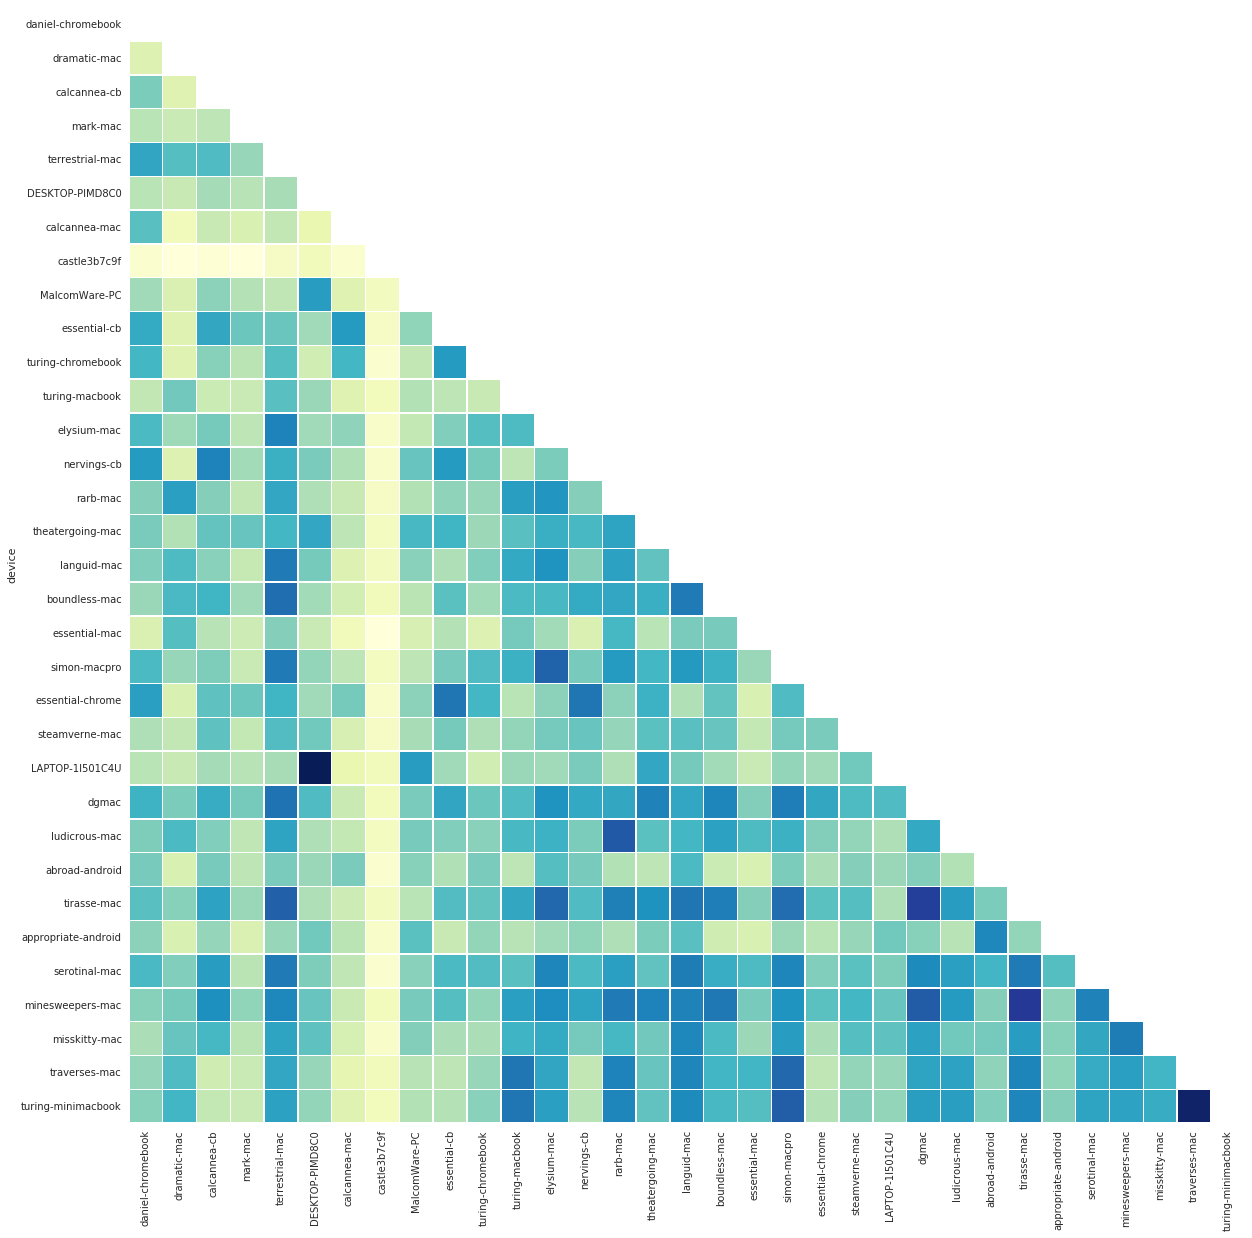

In [16]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, mask=mask, cmap="YlGnBu")
plt.show()